**[Beginner][Tutorial] Intel Image Classification**

Hello, Kagglers!

In this kernel, i will show you how to build the basic model in Tensorflow Keras. First of all i will use Convolutional Neural Network (CNN) in this kernel to predict upto 6 class labels.

First, import the important libraries.

In [1]:
import keras.layers as Layers
import keras.activations as Actications
import keras.models as Models
import keras.optimizers as Optimizer
import keras.metrics as Metrics
import keras.utils as Utils
import keras
from keras.utils.vis_utils import model_to_dot
import os
import matplotlib.pyplot as plot
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
from keras.layers.normalization import BatchNormalization

from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


Now, We need to prepare our data to feed into the model. There is a builtin method in [Keras](https://keras.io/preprocessing/image/) that can extract your images from folders. But, I recommend you to make your own function for this purpose so you can practice the python.

Following is the gernalized function used to extract data from the directory.

In [2]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(299,299)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [3]:
Images, Labels = get_images('../input/seg_train/seg_train/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

Lets find shape of our traing data.

As you see, The Training data is in shape of (Number of Training Images, Width of image, Height of image, Channel of image). This shape is very important. If you didnot resize the images to same size. It should be (No. of images,) shape. So, using this shape you cant feed the images to the model.

In [4]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (14034, 299, 299, 3)
Shape of Labels: (14034,)


Let us look some random images of our dataset.

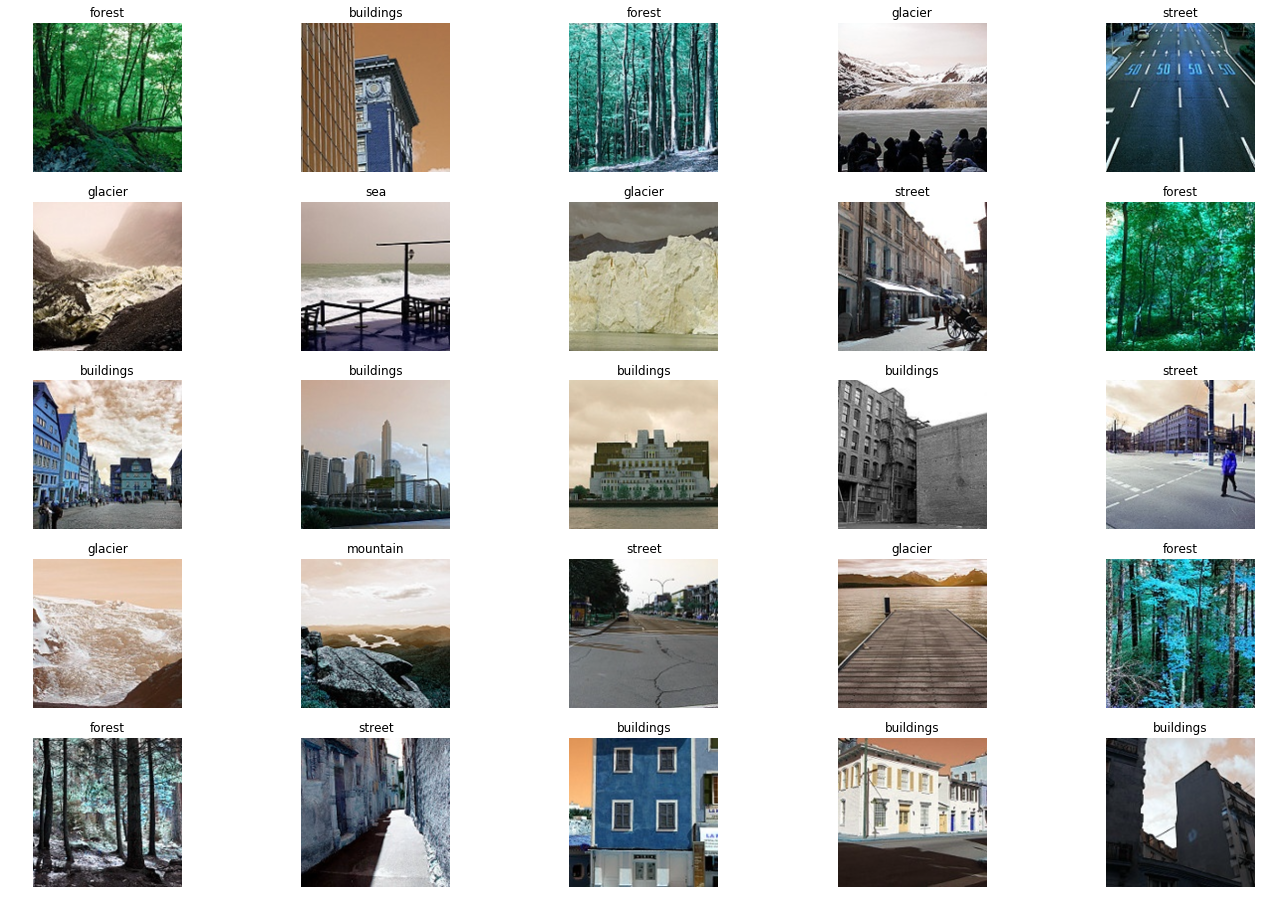

In [5]:
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

Now, Create the CNN model to predict the class labels.This is the basic CNN model.

In [6]:
#InceptionResnetV6
model3= keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#ResNet50
#model3=keras.applications.resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

225214464/225209952 [==============================] - 6s 0us/step


In [7]:
# add a global spatial average pooling layer
x = model3.output
#x = GlobalAveragePooling2D()(x)

#FC Layer 추가
# let's add a fully-connected layer
x = Layers.Dense(512, activation='relu')(x)
x = Layers.Dense(128, activation='relu')(x)
x = Layers.Dense(64, activation='relu')(x)
x=Layers.Dropout(rate=0.5)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Layers.Dense(6, activation='softmax')(x)

# this is the model we will train
model3 = keras.models.Model(inputs=model3.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in model3.layers:
    layer.trainable = True

# compile the model (should be done *after* setting layers to non-trainable)
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

block8_7_ac (Activation)        (None, 8, 8, 2080)   0           block8_7[0][0]                   
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 8, 8, 192)    399360      block8_7_ac[0][0]                
__________________________________________________________________________________________________
batch_normalization_193 (BatchN (None, 8, 8, 192)    576         conv2d_193[0][0]                 
__________________________________________________________________________________________________
activation_193 (Activation)     (None, 8, 8, 192)    0           batch_normalization_193[0][0]    
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 8, 8, 224)    129024      activation_193[0][0]             
__________________________________________________________________________________________________
batch_norm

In [8]:
trained = model3.fit(Images,Labels,epochs=10,validation_split=0.30,verbose=1)

Train on 9823 samples, validate on 4211 samples
Epoch 1/10
9823/9823 [==============================] - 304s 31ms/step - loss: 1.0929 - accuracy: 0.5233 - val_loss: 1.7845 - val_accuracy: 0.4393
Epoch 2/10
9823/9823 [==============================] - 232s 24ms/step - loss: 0.7903 - accuracy: 0.6738 - val_loss: 1.0920 - val_accuracy: 0.6058
Epoch 3/10
9823/9823 [==============================] - 232s 24ms/step - loss: 0.6377 - accuracy: 0.7683 - val_loss: 0.9897 - val_accuracy: 0.6915
Epoch 4/10
9823/9823 [==============================] - 232s 24ms/step - loss: 0.5223 - accuracy: 0.8408 - val_loss: 1.1222 - val_accuracy: 0.7084
Epoch 5/10
9823/9823 [==============================] - 232s 24ms/step - loss: 0.4720 - accuracy: 0.8589 - val_loss: 0.5920 - val_accuracy: 0.8015
Epoch 6/10
9823/9823 [==============================] - 232s 24ms/step - loss: 0.4278 - accuracy: 0.8708 - val_loss: 0.3350 - val_accuracy: 0.8931
Epoch 7/10
9823/9823 [==============================] - 232s 24ms/step

In [9]:
'''
#VGG16 코드로 구현
model = Models.Sequential()

model.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=(128,128,3)))
model.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Layers.MaxPool2D(2,2))

model.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Layers.MaxPool2D(2,2))

model.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Layers.MaxPool2D(2,2))

model.add(Layers.Conv2D(512,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Layers.Conv2D(512,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Layers.Conv2D(512,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Layers.MaxPool2D(2,2))

model.add(Layers.Conv2D(512,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Layers.Conv2D(512,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Layers.Conv2D(512,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Layers.MaxPool2D(2,2))

model.add(Layers.Flatten())
model.add(Layers.Dense(1024,activation='relu'))
model.add(Layers.Dense(512,activation='relu'))
model.add(Layers.Dense(64,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()
#SVG(model_to_dot(model).create(prog='dot', format='svg'))
Utils.plot_model(model,to_file='model.png',show_shapes=True)
'''

"\n#VGG16 코드로 구현\nmodel = Models.Sequential()\n\nmodel.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=(128,128,3)))\nmodel.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))\n#model.add(BatchNormalization())\nmodel.add(Layers.MaxPool2D(2,2))\n\nmodel.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))\nmodel.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))\nmodel.add(Layers.MaxPool2D(2,2))\n\nmodel.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)))\nmodel.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding='same', kernel_initializer='he_

In [10]:
#trained = model.fit(Images,Labels,epochs=35,validation_split=0.30,verbose=1)

Now, lets train the model with validation split equal to 30% from training data. Validation split is used to determine that our model is not geting over-fitted.

In [13]:
trained.history

{'val_loss': [1.7844537538747214,
  1.092003573490361,
  0.9896841802355854,
  1.1221941376462794,
  0.5920165738847697,
  0.33504486316472215,
  0.3761959786307243,
  0.694153765047058,
  0.566315213947731,
  0.5640128121484178],
 'val_accuracy': [0.43932557106018066,
  0.605794370174408,
  0.6915221810340881,
  0.708382785320282,
  0.8014723062515259,
  0.8931370377540588,
  0.8848254680633545,
  0.8014723062515259,
  0.8318688869476318,
  0.8005224466323853],
 'loss': [1.092867739663206,
  0.7903099876611281,
  0.6377315061599408,
  0.5222913755499684,
  0.4719721853617773,
  0.4278054976007014,
  0.3517998390526996,
  0.32622972759709734,
  0.3373107167237113,
  0.2956015537211818],
 'accuracy': [0.5232617,
  0.67382675,
  0.76829886,
  0.84078187,
  0.8589026,
  0.87081337,
  0.8975873,
  0.90084493,
  0.8971801,
  0.9132648]}

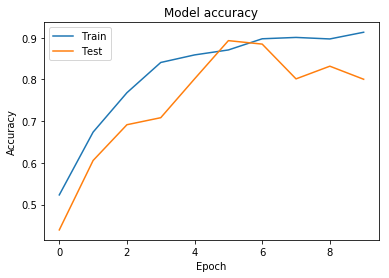

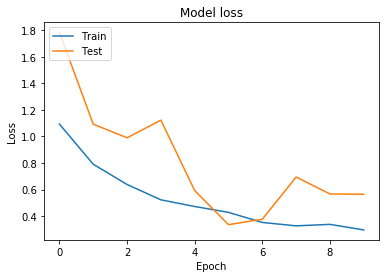

In [14]:
plot.plot(trained.history['accuracy'])
plot.plot(trained.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

To evaluate a model, there are many methods are proposed to evaluate the model. I use Accuracy to evaluate the performance of my model.

In [15]:
test_images,test_labels = get_images('../input/seg_test/seg_test/')
test_images = np.array(test_images)
test_labels = np.array(test_labels)
model3.evaluate(test_images,test_labels, verbose=1)

3000/3000 [==============================] - 20s 7ms/step


[0.5928421017328898, 0.7863333225250244]

Lets predict the images from the "pred" folder.

In [18]:
pred_images,no_labels = get_images('../input/seg_pred/')
pred_images = np.array(pred_images)
pred_images.shape

(7301, 299, 299, 3)

Following image shows the predicted class label on top of the image and probabilities below of the image.

In [24]:
np.argmax(model3.predict(pred_image))

5

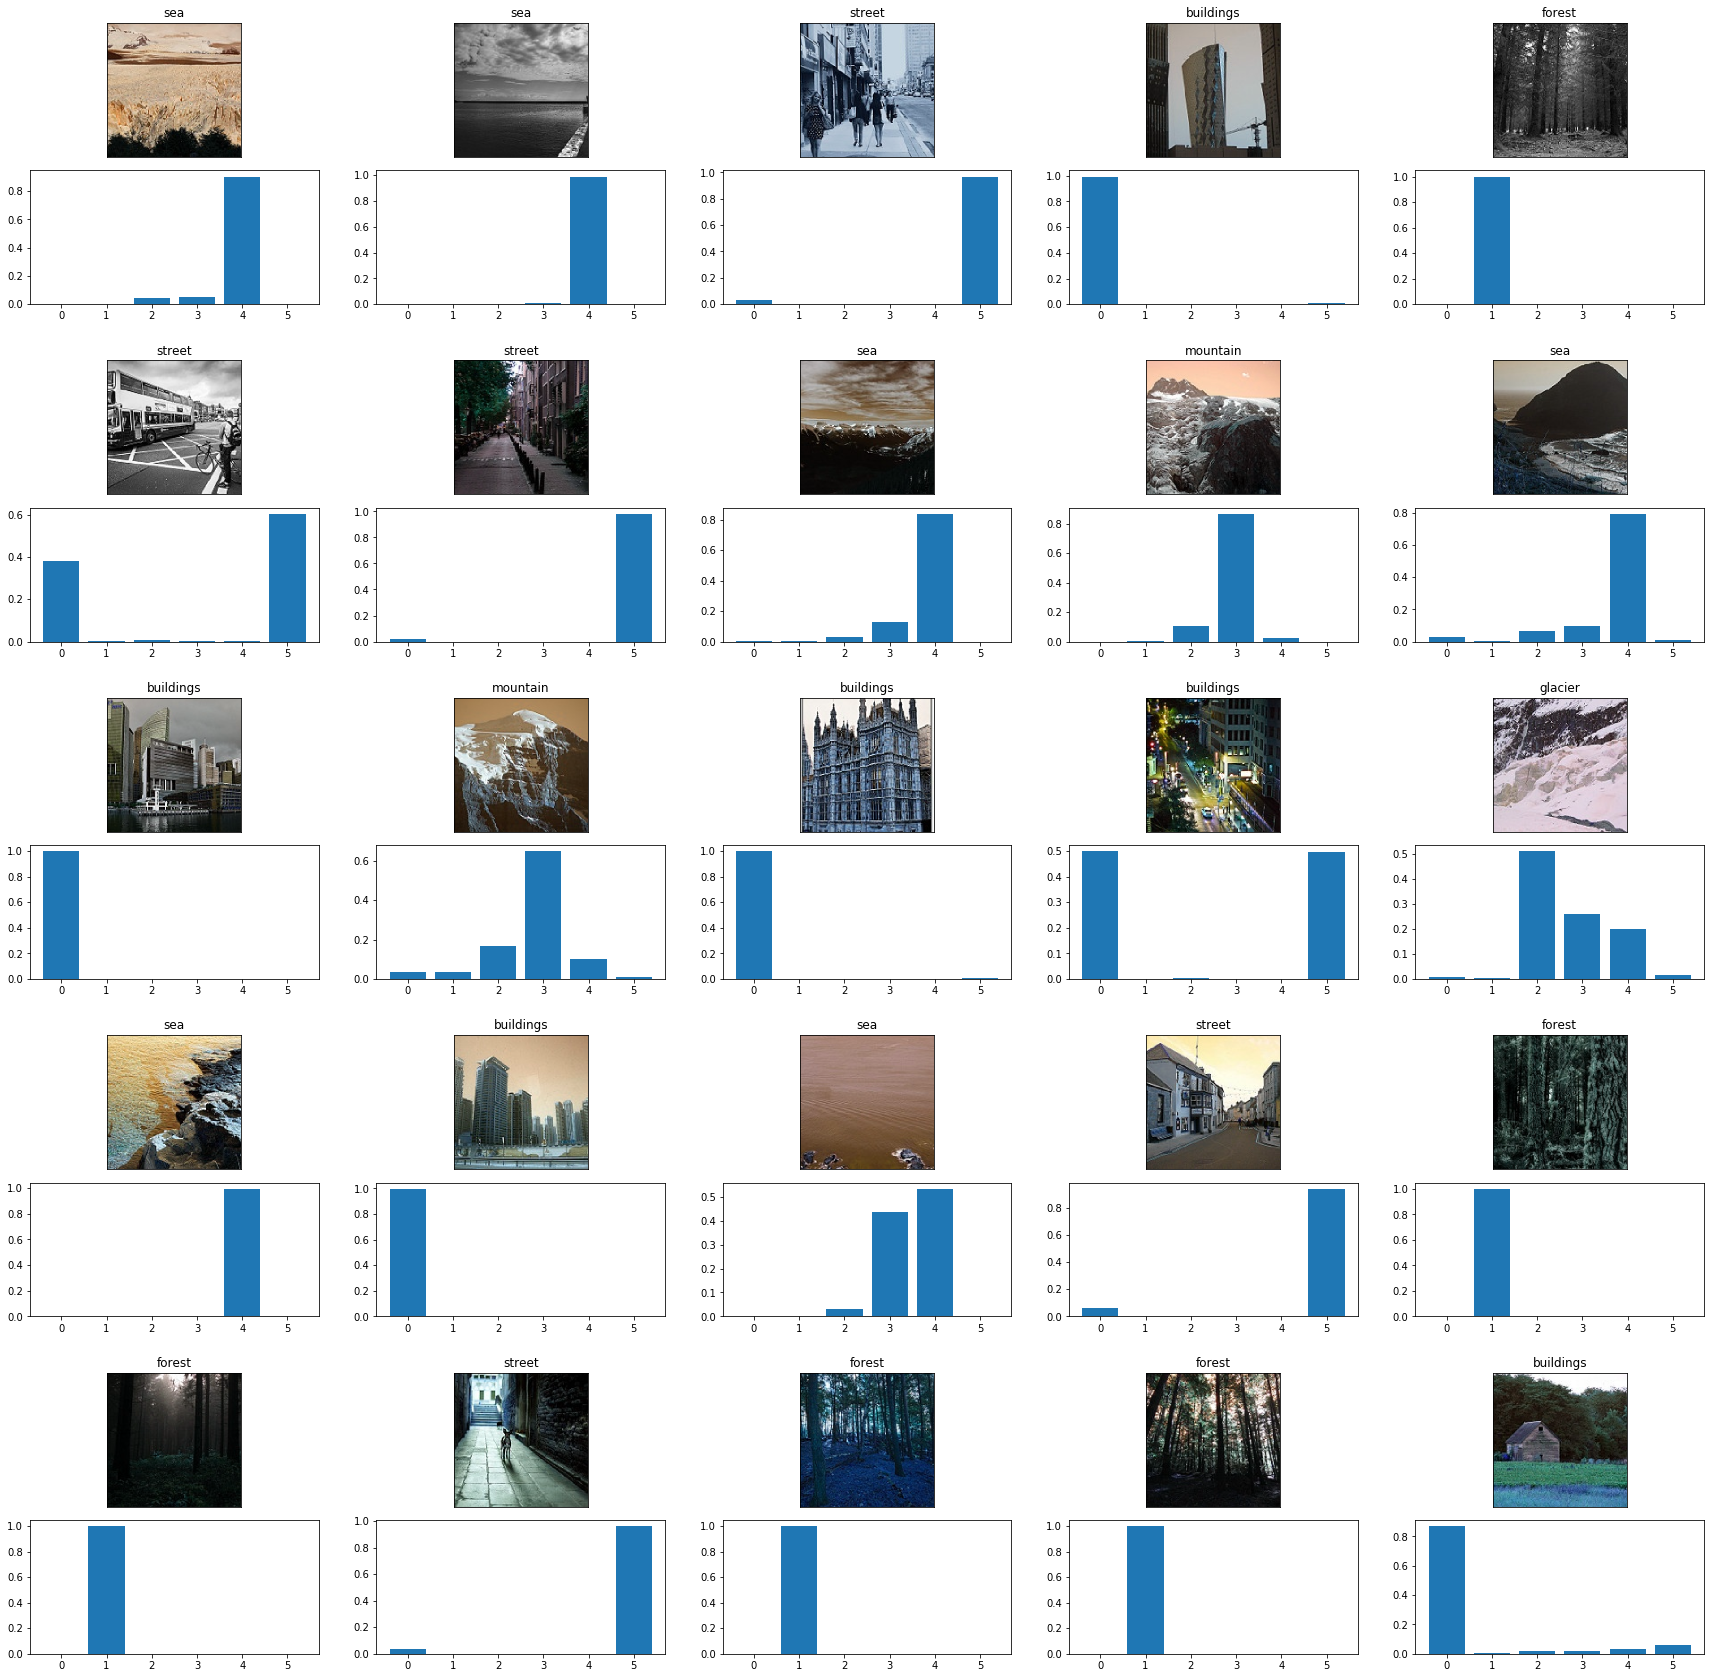

In [25]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_classlabel(np.argmax(model3.predict(pred_image)))
    pred_prob = model3.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)


fig.show()

I hope you like my kernel. Feel free to ask any question in the comment section. I am looking forward for your **sugestions**!